In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))

# Any results you write to the current directory are saved as output.

['desktop.ini', 'ELO']


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')
hist_trans = pd.read_csv('../ELO/historical_transactions.csv')
#new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [5]:
#hist_trans=reduce_mem_usage(hist_trans)
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


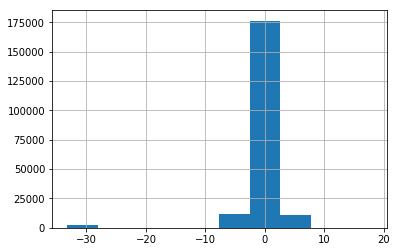

In [13]:
import matplotlib.pyplot as plt
train.target.hist()

In [21]:
train[train.target<-10].shape,train[train.target>5].shape

((2264, 6), (1742, 6))

In [65]:
train[train.target<-10].to_csv('Least Loyal.csv',index=False)
train[train.target>5].to_csv('Most Loyal.csv',index=False)

In [27]:
train_cust_list=list(train[train.target<-10].card_id.values)+list(train[train.target>5].card_id.values)
train_cust_list[1:5]

['C_ID_b9379a30ea', 'C_ID_e9120f535c', 'C_ID_65715cb80d', 'C_ID_ae77d244b6']

In [33]:
test_cust_list=list(test.card_id)[:5000]

In [35]:
embed_cust_list=train_cust_list+test_cust_list
len(embed_cust_list)

9006

In [39]:
#Filter  hist transactions
fil_merch=hist_trans[hist_trans.card_id.isin(embed_cust_list)]
#.groupby(['card_id']).agg({'purchase_amount':['sum','count']})
fil_merch.shape,hist_trans.shape

((734037, 14), (29112361, 14))

In [40]:
df_cid_mid_filtered=fil_merch.loc[:,['card_id','merchant_id']]
#df_cid_mid.drop_duplicates(inplace=True)
df_cid_mid_filtered.dropna(inplace=True)
df_cid_mid_filtered['weight']=1
df_cid_mid_filtered=df_cid_mid_filtered.groupby(['card_id','merchant_id']).agg({'weight':'count'})
df_cid_mid_filtered.columns = [''.join(col).strip() for col in df_cid_mid_filtered.columns.values]
df_cid_mid_filtered.reset_index(inplace=True)
#
df_cid_mid_filtered.head()

,card_id,merchant_id,weight
0,C_ID_00087f3079,M_ID_00a6ca8a8a,7
1,C_ID_00087f3079,M_ID_070f18bfd0,2
2,C_ID_00087f3079,M_ID_079ed19994,2
3,C_ID_00087f3079,M_ID_081783973b,1
4,C_ID_00087f3079,M_ID_11c1ad802f,2


In [41]:
df_cid_mid_filtered.shape

(280693, 3)

In [63]:
df_cid_mid_filtered[df_cid_mid_filtered.card_id=='C_ID_f008e08959']

,card_id,merchant_id,weight
263658,C_ID_f008e08959,M_ID_00a6ca8a8a,4
263659,C_ID_f008e08959,M_ID_00c2f2ad26,1
263660,C_ID_f008e08959,M_ID_2394e530e2,1
263661,C_ID_f008e08959,M_ID_36e0005381,1
263662,C_ID_f008e08959,M_ID_45e0428325,5
263663,C_ID_f008e08959,M_ID_5278375b22,1
263664,C_ID_f008e08959,M_ID_59764e8cb1,1
263665,C_ID_f008e08959,M_ID_641dbf98bd,1
263666,C_ID_f008e08959,M_ID_653706dbfb,3
263667,C_ID_f008e08959,M_ID_6b2b2c3ccd,1


In [62]:
df_cid_mid_filtered[df_cid_mid_filtered.card_id=='C_ID_0029d52418']

,card_id,merchant_id,weight
87,C_ID_0029d52418,M_ID_00a6ca8a8a,4
88,C_ID_0029d52418,M_ID_0e84b2e9d6,1
89,C_ID_0029d52418,M_ID_1440c83173,1
90,C_ID_0029d52418,M_ID_2637773dd2,1
91,C_ID_0029d52418,M_ID_2a89f77b14,1
92,C_ID_0029d52418,M_ID_3111c6df35,14
93,C_ID_0029d52418,M_ID_3700a4ec5f,26
94,C_ID_0029d52418,M_ID_497442dc4f,2
95,C_ID_0029d52418,M_ID_72949e0f75,1
96,C_ID_0029d52418,M_ID_820c7b73c8,1


In [42]:
import networkx as nx

In [43]:
G=nx.from_pandas_edgelist(df_cid_mid_filtered,'card_id', 'merchant_id', ['weight'])

In [44]:
#Create dicts for bipartite attributes
my_dict = {}
for i in list(df_cid_mid_filtered.card_id.unique()):
    my_dict[i] = 0

my_dict2 = {}
for i in list(df_cid_mid_filtered.merchant_id.unique()):
    my_dict2[i] = 1

In [45]:
nx.set_node_attributes(G, my_dict,'bipartite')
nx.set_node_attributes(G, my_dict2,'bipartite')

In [46]:
nx.write_gpickle(G, "CID_MID_filtered.gpickle")

In [48]:
def my_weight(G, u, v, weight='weight'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        w += G.edges[u,nbr].get(weight, 1) + G.edges[v,nbr].get(weight, 1)
        return w

In [66]:
#Customer projection -1
CP1 = nx.bipartite.generic_weighted_projected_graph(G,list(df_cid_mid_filtered.card_id.unique())[1:100],weight_function=my_weight)

In [56]:
nx.write_gpickle(CP1, "CP1_test.gpickle")

C:\Users\akhilkandregula\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


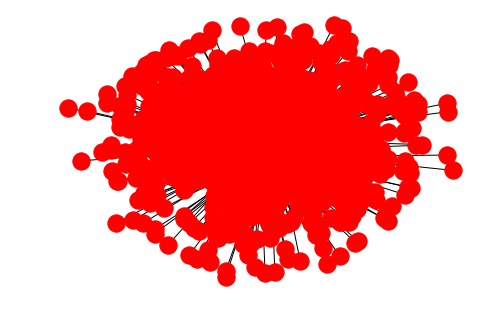

In [67]:
# Separate by group
#l, r = nx.bipartite.sets(CP1)
#l,r=list(df_cid_mid_filtered.card_id.unique()),list(df_cid_mid_filtered.merchant_id.unique())
#pos = {}

# Update position for node from each group
#pos.update((node, (1, index)) for index, node in enumerate(l))
#pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(CP1,with_labels = False,size=0.1,pos=nx.spring_layout(CP1))
plt.show()

In [35]:
fil_merch=hist_trans.groupby(['merchant_id']).agg({'purchase_amount':['sum','count']})
fil_merch.columns=['_'.join(col).strip() for col in fil_merch.columns.values]
fil_merch.reset_index(inplace=True)
#.reset_index().sort_values(['purchase_amount'])

In [ ]:
fil_merch.head()

In [36]:
#fil_merch/fil_merch.apply('sum',axis=0)

In [14]:
hist_trans.loc[:,['category_1','category_3','category_2']].drop_duplicates().count()

category_1    28
category_3    21
category_2    20
dtype: int64

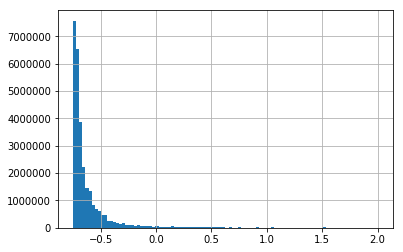

In [25]:
import matplotlib.pyplot as plt
hist_trans[hist_trans.purchase_amount<2].purchase_amount.hist(bins=100)

In [12]:
len(hist_trans.merchant_category_id.unique()),len(hist_trans.card_id.unique())
#hist_trans.merchant_id.value_counts()

(327, 325540)

In [ ]:
#merchants = pd.read_csv('../input/merchants.csv')

In [ ]:
#merchants.head()

In [ ]:
#len(merchants.merchant_id.unique()),len(merchants.merchant_group_id.unique()),len(merchants.merchant_category_id.unique())

In [ ]:
#merchants.merchant_group_id.value_counts().plot(kind='bar')
#ak[ak>100].hist(bins=10)

In [ ]:
#nm

In [ ]:
#nm=merchants.loc[:,['merchant_id','merchant_group_id','merchant_category_id']]

In [ ]:
#nm.drop_duplicates().count()
#nm.loc[:,['merchant_id','merchant_group_id']].drop_duplicates().count(),nm.loc[:,['merchant_id']].drop_duplicates().count()

In [6]:
df_cid_mid=hist_trans.loc[:,['card_id','merchant_id']]
#df_cid_mid.drop_duplicates(inplace=True)
df_cid_mid.dropna(inplace=True)
df_cid_mid['weight']=1
df_cid_mid=df_cid_mid.groupby(['card_id','merchant_id']).agg({'weight':'count'})
df_cid_mid.columns = [''.join(col).strip() for col in df_cid_mid.columns.values]
df_cid_mid.reset_index(inplace=True)
#
df_cid_mid.head()

,card_id,merchant_id,weight
0,C_ID_00007093c1,M_ID_0379adb435,4
1,C_ID_00007093c1,M_ID_06a8d84366,1
2,C_ID_00007093c1,M_ID_0dabc5a70c,2
3,C_ID_00007093c1,M_ID_109e9d2b1d,2
4,C_ID_00007093c1,M_ID_15446e939c,4


In [10]:
df_cid_mid.shape,df_cid_mid.dropna().shape,df_cid_mid.drop_duplicates().shape

((10981505, 3), (10981505, 3), (10981505, 3))

In [11]:
df_cid_mid[df_cid_mid['merchant_id']=='M_ID_9f65cd13d1']

,card_id,merchant_id,weight
631859,C_ID_0ebfe3f006,M_ID_9f65cd13d1,2
794103,C_ID_128b9fca87,M_ID_9f65cd13d1,2
1432580,C_ID_215436c7ce,M_ID_9f65cd13d1,1
1917978,C_ID_2c95c2965e,M_ID_9f65cd13d1,2
2166992,C_ID_325f2f1a8f,M_ID_9f65cd13d1,1
3734168,C_ID_5701713924,M_ID_9f65cd13d1,2
4109283,C_ID_5fb5a324ab,M_ID_9f65cd13d1,1
5126519,C_ID_77450d0b62,M_ID_9f65cd13d1,1
5228118,C_ID_79bc868f9e,M_ID_9f65cd13d1,4
6244677,C_ID_9129cd2ed4,M_ID_9f65cd13d1,1


In [8]:
df_cid_mid[df_cid_mid['weight']==1].shape

(6746414, 3)

In [12]:
df_cid_mid.to_csv('card_merchant.csv',index=False)

In [ ]:
# apk=df_cid_mid.groupby('merchant_id').agg({'card_id':'count'}).reset_index()
# apk.head()

# apk=df_cid_mid.groupby('card_id').agg({'merchant_id':'count'}).reset_index()
# apk.head()

In [ ]:
#apk[apk.merchant_id<20].merchant_id.hist(bins=100)

In [16]:
df_mid_mcid=hist_trans.loc[:,['merchant_id','merchant_category_id']]
df_mid_mcid.dropna(inplace=True)
df_mid_mcid['weight']=1
df_mid_mcid=df_mid_mcid.groupby(['merchant_id','merchant_category_id']).agg({'weight':'count'})
df_mid_mcid.columns = [''.join(col).strip() for col in df_mid_mcid.columns.values]
df_mid_mcid.reset_index(inplace=True)
#df_mid_mcid.to_csv('merchant_category.csv',index=False)
df_mid_mcid.head()

,merchant_id,merchant_category_id,weight
0,M_ID_000025127f,80,9
1,M_ID_0000699140,87,57
2,M_ID_00006a5552,178,1
3,M_ID_000087311e,206,15
4,M_ID_000087311e,748,7


In [17]:
df_mid_mcid.to_csv('merchant_category.csv',index=False)

In [ ]:
# df_mid_mcid.drop_duplicates(inplace=True)
# df_mid_mcid.dropna(inplace=True)
# df_mid_mcid.count()

In [15]:
df_cid_mid.head()

,card_id,merchant_id,weight
0,C_ID_00007093c1,M_ID_0379adb435,4
1,C_ID_00007093c1,M_ID_06a8d84366,1
2,C_ID_00007093c1,M_ID_0dabc5a70c,2
3,C_ID_00007093c1,M_ID_109e9d2b1d,2
4,C_ID_00007093c1,M_ID_15446e939c,4


In [18]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#list(df_cid_mid.card_id.unique())
#tuple(df_cid_mid.iloc[1,:].values)

In [19]:
from tqdm import tqdm

In [ ]:
#edges=[tuple(df_cid_mid.iloc[i,:].values) for i in tqdm(range(len(df_cid_mid.iloc[:,:])))]

In [20]:
G=nx.from_pandas_edgelist(df_cid_mid,'card_id', 'merchant_id', ['weight'])

In [21]:
#Create dicts for bipartite attributes
my_dict = {}
for i in list(df_cid_mid.card_id.unique()):
    my_dict[i] = 0

my_dict2 = {}
for i in list(df_cid_mid.merchant_id.unique()):
    my_dict2[i] = 1


In [22]:
len(list(G.nodes)),len(list(df_cid_mid.card_id.unique()))+len(list(df_cid_mid.merchant_id.unique()))

(651851, 651851)

In [ ]:
#list(df_cid_mid.merchant_id.unique())[-15:-1]

In [23]:
nx.set_node_attributes(G, my_dict,'bipartite')

In [24]:
nx.set_node_attributes(G, my_dict2,'bipartite')

In [25]:
nx.write_gpickle(G, "CID_MID.gpickle")

In [26]:
def my_weight(G, u, v, weight='weight'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        w += G.edges[u,nbr].get(weight, 1) + G.edges[v,nbr].get(weight, 1)
        return w

In [ ]:
#G=nx.from_pandas_edgelist(df_cid_mid,'card_id', 'merchant_id', ['count'])

#Customer projection -1
CP1 = nx.bipartite.generic_weighted_projected_graph(G,list(df_cid_mid.card_id.unique()),weight_function=my_weight)

In [ ]:
nx.write_gpickle(CP1, "CP1.gpickle")

In [ ]:
# Separate by group
#l, r = nx.bipartite.sets(G)
l,r=list(df_cid_mid.card_id.unique()),list(df_cid_mid.merchant_id.unique())
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(G, pos=pos)
plt.show()

In [ ]:
bk

In [ ]:
#G['C_ID_4e6213e9bc']['M_ID_e020e9b302']
G.nodes['C_ID_4e6213e9bc']['bipartite']
G.nodes['M_ID_e020e9b302']['bipartite']

In [ ]:
df.set_index('ID').T.to_dict('list')

In [ ]:
df_cid_mid.head(10)

In [ ]:
C=nx.Graph()
C.add_nodes_from(list(df_cid_mid.card_id.unique()), bipartite=0) # Add the node attribute "bipartite"

In [ ]:
C.add_nodes_from(list(df_cid_mid.merchant_id.unique()), bipartite=1) # Add the node attribute "bipartite"

In [ ]:
C.add_weighted_edges_from(edges) ## Added edges

In [ ]:
B.nodes['a']['bipartite']

In [ ]:
B = nx.Graph()
B.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(['a','b','c'], bipartite=1)
B.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a'),(2,'a')])
#B.add_weighted_edges_from([(1,'a',3), (1,'b',10), (2,'b',1), (2,'c',1), (3,'c',30), (4,'a',4)])

# Separate by group
l, r = nx.bipartite.sets(B)
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(B,with_labels = True, pos=pos)
plt.show()

In [ ]:
C = nx.Graph()
C.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
C.add_nodes_from(['a','b','c','k','d','e'], bipartite=1)
C.add_edges_from([(3,'a'), (2,'b'), (4,'b'), (2,'c'), (3,'c'), (1,'a'),(2,'k'),(1,'d'),(2,'e')])
#B.add_weighted_edges_from([(1,'a',3), (1,'b',10), (2,'b',1), (2,'c',1), (3,'c',30), (4,'a',4)])

# Separate by group
l, r = nx.bipartite.sets(C)
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(C,with_labels = True, pos=pos)
plt.show()

In [ ]:
K1 = nx.bipartite.weighted_projected_graph(B, [1,2,3,4])
K2 = nx.bipartite.weighted_projected_graph(B, [1,2,3,4])

In [ ]:
list(K1.edges(data=True)),list(K2.edges(data=True))

In [ ]:
list(combined_graphs_edges(K1,K2,1))

In [ ]:
graph = nx.Graph()
graph.add_edges_from(combined_graphs_edges(K1,K2,weight=0.5))
labels = nx.get_edge_attributes(graph,'weight')
print('weights',labels)
nx.draw_networkx(graph,with_labels = True, pos=nx.spring_layout(graph),edge_color =[10,5.5,0.5,0.5],width =5)
plt.show()

In [ ]:
def combined_graphs_edges(G, H, weight = 1.0):
    for u,v,hdata in H.edges(data=True):
        # multply attributes of H by weight
        attr = dict( (key, value*weight) for key,value in hdata.items())
        # get data from G or use empty dict if no edge in G
        gdata = G[u].get(v,{})
        # add data from g
        # sum shared items
        shared = set(gdata) & set(hdata)
        attr.update(dict((key, attr[key] * gdata[key]) for key in shared))
        # non shared items
        non_shared = set(gdata) - set(hdata)
        attr.update(dict((key, gdata[key]) for key in non_shared))
        yield u,v,attr
    return

In [ ]:
import matplotlib.pyplot as plt
nx.draw(K,with_labels=True)
#nx.draw(B,with_labels = True, pos=pos)
plt.show()

In [ ]:
K.nodes[1]